I implemented it with reference to this code:
https://github.com/bacnguyencong/rbm-pytorch

In [150]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [151]:
batch_size = 128 # batch size
n_epochs = 10 # number of epochs
lr = 0.01 # learning rate
n_hid = 100 # number of neurons in the hidden layer
n_vis = 28*28 # input size
k = 3 # The number of Gibbs sampling

In [152]:
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid, k=1, *args, **kwargs):
        super(RBM, self).__init__(*args, **kwargs)
        self.v = nn.Parameter(torch.randn(1, n_vis))
        self.h = nn.Parameter(torch.randn(1, n_hid))
        self.W = nn.Parameter(torch.randn(n_hid, n_vis))
        self.k = k

    def visible_to_hidden(self, v):
        p = torch.sigmoid(F.linear(v, self.W, self.h))
        return p.bernoulli()

    def hidden_to_visible(self, h):
        p = torch.sigmoid(F.linear(h, self.W.t(), self.v))
        return p.bernoulli()

    def free_energy(self, v):
        v_term = torch.matmul(v, self.v.t())
        w_x_h = F.linear(v, self.W, self.h)
        h_term = torch.sum(F.softplus(w_x_h), dim=1)
        return torch.mean(-h_term - v_term)

    def forward(self, v):
        h = self.visible_to_hidden(v)
        for _ in range(self.k):
            v_gibb = self.hidden_to_visible(h)
            h = self.visible_to_hidden(v_gibb)
        return v_gibb

In [153]:
# create a Restricted Boltzmann Machine
model = RBM(n_vis=n_vis, n_hid=n_hid, k=k)

In [154]:
train_datasets = datasets.MNIST(
    root='./output',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
    )
train_loader = torch.utils.data.DataLoader(
    dataset=train_datasets,
    batch_size=batch_size,
    shuffle=True,
)

In [155]:
def neuron_fireing_vis():
    vv1 = np.zeros((len(train_datasets), n_hid))

    for idx, (x, y) in enumerate(train_loader):
        x = x.view(-1, n_vis)
        vv1[idx*batch_size:(idx+1)*batch_size, :] = model.visible_to_hidden(x).detach().numpy() # [batch_size, n_hid]
    return vv1

In [156]:
from tqdm import tqdm

loss_ = []
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model.train()


neuron_fireings = []
neuron_fireings.append(neuron_fireing_vis())
with tqdm(range(n_epochs)) as t:
    for epoch in t:
        for (data, target) in train_loader:
            v = data.view(-1, n_vis)
            v_gibbs = model(v)
            loss = model.free_energy(v) - model.free_energy(v_gibbs)
            loss_.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f"loss={loss.item():.2}")
        neuron_fireings.append(neuron_fireing_vis())


loss=1e+01: 100%|██████████| 10/10 [03:26<00:00, 20.66s/it]


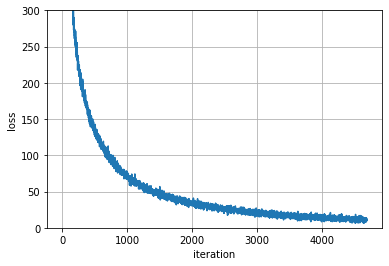

In [157]:
import matplotlib.pyplot as plt

plt.plot(loss_)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(0, 300)
plt.grid()

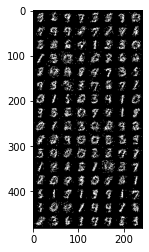

In [158]:
from torchvision.utils import make_grid

images = next(iter(train_loader))[0]
v = images.view(-1, 784)
v_gibbs = model(images.view(-1, 784))
npimg = np.transpose(make_grid(v_gibbs.view(batch_size, 1, 28, 28).data).numpy(), (1, 2, 0))
plt.imshow(npimg, cmap="gray")

In [159]:
vv1 = np.zeros((len(train_datasets), n_hid))

for idx, (x, y) in enumerate(train_loader):
    x = x.view(-1, n_vis)
    vv1[idx*batch_size:(idx+1)*batch_size, :] = model.visible_to_hidden(x).detach().numpy() # [batch_size, n_hid]

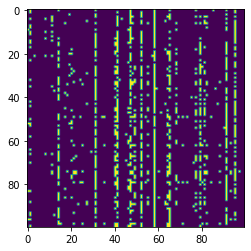

In [160]:
plt.imshow(vv1[:100, :])


In [161]:
import sklearn
from sklearn.decomposition import PCA

vv1 = sklearn.preprocessing.scale(vv1)

In [162]:
pca = PCA()
pca.fit(vv1)
print(pca.explained_variance_)

[9.11435081 4.88942475 3.8773274  2.59329057 2.49938612 2.23953876
 2.1484882  1.76639967 1.55507555 1.46526404 1.2951985  1.27379812
 1.18553643 1.16653179 1.14084021 1.12710557 1.11128397 1.10430719
 1.09375342 1.08657971 1.08092265 1.06926275 1.06129429 1.05507166
 1.05079832 1.04947    1.04119451 1.03126219 1.01997251 1.01712211
 1.01413605 1.01129519 1.00335776 0.99658512 0.99429476 0.99216009
 0.98286439 0.97494611 0.96226341 0.96117613 0.95927923 0.94969248
 0.94787765 0.94481962 0.93903639 0.935266   0.93351302 0.92367525
 0.91856669 0.9170006  0.90694842 0.89958473 0.88679938 0.88301927
 0.87984936 0.87575202 0.85984958 0.85250933 0.82847994 0.82511472
 0.78782226 0.77305396 0.75477491 0.73390836 0.69599059 0.6823824
 0.64312612 0.62456915 0.60212137 0.59357696 0.57913326 0.57652989
 0.55954512 0.53915577 0.52659042 0.51248792 0.505412   0.49061968
 0.43646616 0.42836141 0.40839187 0.39598627 0.39064432 0.35793915
 0.34937674 0.34048952 0.33211639 0.31379529 0.31096086 0.29572

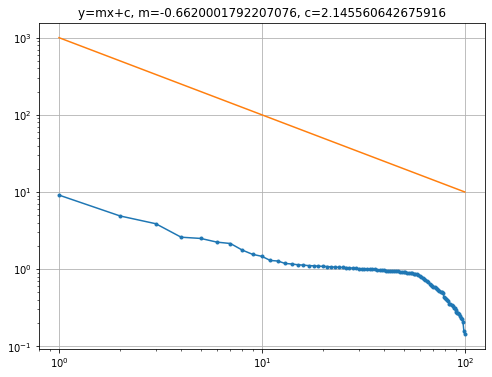

In [163]:
fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(len(pca.explained_variance_)) + 1
ax.plot(xx, pca.explained_variance_, '.-')
ax.plot(xx, 1000 * xx ** (-1.0))

ax.set_xscale('log')
ax.set_yscale('log')
xx = np.log(xx)
yy = np.log(pca.explained_variance_)
m, c = np.linalg.lstsq(np.vstack([xx, np.ones(len(xx))]).T, yy, rcond=None)[0]
ax.set_title(f'y=mx+c, m={m}, c={c}')
ax.grid()

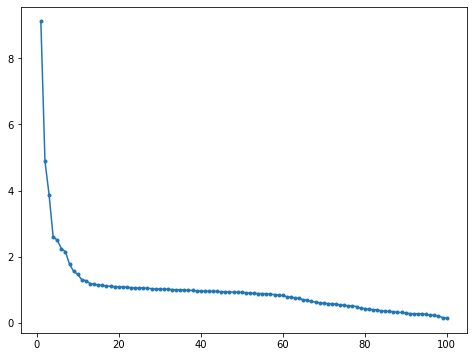

In [164]:
fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(len(pca.explained_variance_)) + 1
ax.plot(xx, pca.explained_variance_, '.-')

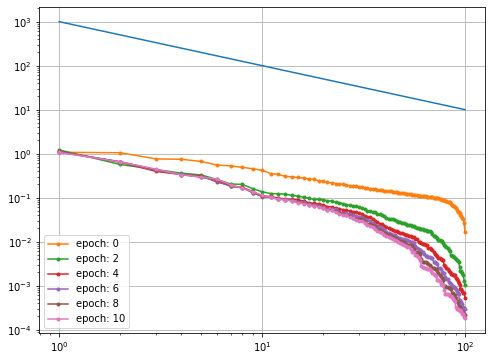

In [165]:
fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(len(pca.explained_variance_)) + 1
ax.plot(xx, 1000 * xx ** (-1.0))
ax.set_xscale('log')
ax.set_yscale('log')
for i, vv in enumerate(neuron_fireings):
    if i % 2 == 1:
        continue
    pca = PCA()
    pca.fit(vv)
    ax.plot(xx, pca.explained_variance_, '.-', label=f"epoch: {i}")
plt.legend()
ax.grid()